In [22]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import neural

import enum
import json
from typing import Optional

## Model Config, ignore this now

In [20]:
class ModelConfig:
    def __init__(self, layers: list[int], activation_function: str):
        self.layers = layers
        self.activation_function = activation_function
        
    def create_model(self) -> neural.NN:
        neural.NN(self.layers, eval(self.activation_function))
    
    def to_json(self):
        info = {"layers": self.layers, "activation_function": self.activation_function.__name__}
        return json.dumps(info)
    
    @classmethod
    def from_json(cls, json_info: str):
        info = json.loads(json_info)
        self = cls(info["layers"], info["activation_function"])
        return self
        

In [23]:
class OptimizerConfig:
    def __init__(self, optimizer, **args):
        self.optimizer = optimizer
        self.args = args
        
    def create_optimizer(self, model: torch.nn.Module):
        return eval(self.optimizer)(model, **args)


class LrSchedulerConfig:
    def __init__(self, lr_scheduler, **args):
        self.lr_scheduler = lr_scheduler
        self.args = args
        
    def create_scheduler(self, optimizer: torch.optim.Optimizer) -> torch.optim.lr_scheduler.LRScheduler:
        return eval(self.lr_scheduler)(optimizer, **self.args)


class LambdaSchedulerConfig:
    def __init__(self, lambda_scheduler, **args):
        self.lambda_scheduler = lambda_scheduler
        self.args = args


class TrainerConfig:
    def __init__(
            self,
            optimizer_config: OptimizerConfig,
            lr_scheduler_config: Optional[LrSchedulerConfig],
            lambda_scheduler_config: Optional[LambdaSchedulerConfig]):

        self.optimizer_config = optimizer_config
        self.lr_scheduler_config = lr_scheduler_config
        self.lambda_scheduler_config = lambda_scheduler_config
        
    def create_the_thing(self, model):
        optimizer = self.optimizer_config.create_optimizer(model)
        if self.lr_scheduler_config is not None:
            self.lr_scheduler_config.create_scheduler(optimizer)
        else:
            lr_scheduler = None
        
        return (optimizer, lr_scheduler)

In [15]:
model_config = ModelConfig(
    [1, 4, 4, 4, 1], "tanh"
)

trainer_config = TrainerConfig(
    {
        "base": "torch.optim.Adam",
        "args": {"lr": 0.001}
    },
    {
        "base": "torch.optim.lr_scheduler.LRExponential",
        "args": {"gamma": 0.999}
    },
    lambda_scheduler=None
)

model = model_

optimizer = trainer_config.optimizer["base"](model.parameters(), **trainer_config.optimizer["args"])

In [5]:
model = neural.NN([2, 5, 5, 2])
optim = torch.optim.Adam(model.parameters(), 0.001)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optim)

lr_scheduler.print_lr()


TypeError: LRScheduler.print_lr() missing 3 required positional arguments: 'is_verbose', 'group', and 'lr'

In [ ]:
class BasicConfiguration:
    def __init__(self, layers, activation_function):
        self.layers = layers
        self.activation_function = activation_function
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler

In [39]:
class Training:
    def __init__(self, model: neural.NN, optimizer, lr_scheduler):
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        

optimizer = torch.optim.Adam(lr=0.001)

train = Training(optimizer)

TypeError: Adam.__init__() missing 1 required positional argument: 'params'

# Start Here

In [32]:
T = 10
L = 1
n_ic = 100
n_bc = 100

t_start = 1
t_end = 2

x_ic = torch.stack([torch.linspace(0, L, n_ic), torch.zeros(n_ic)])
y_ic = torch.zeros((2, n_ic))


t_array = torch.linspace(0, T, n_bc)
pulse = torch.ones(n_bc)
zeros = torch.zeros(n_bc)
pulse[t_array < t_start] = 0
pulse[t_array > t_end] = 0

x_bc_l = torch.stack([torch.zeros(n_bc), t_array], 0)
y_bc_l = pulse.reshape(1, -1)

x_bc_r = torch.stack([torch.ones(n_bc), t_array], 0)

## Loss Functions

In [33]:
def get_data_loss(model: neural.NN, x_train, y_train):
    y_nn = model(x_train)
    loss = torch.mean(torch.square(y_nn - y_train))
    return loss


def get_physics_loss(model: neural.NN, x_train, coeff):
    y_nn = model(x_train)

    v_grad = torch.autograd.grad(
        y_nn[0,:],
        x_train,
        grad_outputs=torch.ones_like(y_nn[0,:]),
        retain_graph=True,
        create_graph=True
    )[0]
    i_grad = torch.autograd.grad(
        y_nn[1,:],
        x_train,
        grad_outputs=torch.ones_like(y_nn[1,:]),
        retain_graph=True,
        create_graph=True
    )[0]

    v_x = v_grad[0, :]
    v_t = v_grad[1, :]
    i_x = i_grad[0, :]
    i_t = i_grad[1, :]
    
    v_x_grad = torch.autograd.grad(
        v_x,
        x_train,
        grad_outputs=torch.ones_like(v_x),
        retain_graph=True
    )[0]

    i_x_grad = torch.autograd.grad(
        i_x,
        x_train,
        grad_outputs=torch.ones_like(v_x),
        retain_graph=True
    )[0]
    
    v_xx = v_x_grad[0,:]
    i_xx = i_x_grad[0,:]
    
    gamma = 0.05
    
    eq_1 = v_x + coeff.L * i_t + coeff.R * y_nn[1,:] + gamma * i_xx
    eq_2 = i_x + coeff.C * v_t + coeff.G * y_nn[0,:] * gamma * v_xx
    
    full_error = torch.stack((eq_1, eq_2), 0)

    return torch.mean(torch.square(full_error))

class Coefficients:
    def __init__(self):
        self.L = 3.0
        self.C = 3.0
        self.R = 0.01
        self.G = 1/10**5

x_train = torch.tensor([[0., 1., 2.], [0., 1., 2.]])
# x_train = torch.tensor([[0.], [0.]])
x_train.requires_grad_(True)
model = neural.NN([2, 5, 5, 5, 2])

output = get_physics_loss(model, x_train, Coefficients())

In [34]:
coeff = Coefficients()
model = neural.NN([2, 5, 5, 5, 5, 2])
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr)

ic_loss_hist = []
bc_loss_hist = []
phys_loss_hist = []

for epoch in range(50000):
    lambda_phys =  2
    if epoch % 10000 == 0:
        x_phys = np.random.uniform(0, L, 2000)
        t_phys = np.random.uniform(0, T, 2000)
        x_phys = np.stack([x_phys, t_phys], 0)
        x_phys = torch.tensor(x_phys, dtype=torch.float, requires_grad=True)

    optimizer.zero_grad()
    ic_loss = get_data_loss(model, x_ic, y_ic)
    bc_l_loss = torch.mean(torch.square(model(x_bc_l)[0,:] - y_bc_l))
    
    r_nn = model(x_bc_r)
    bc_r_loss = torch.mean(torch.square(r_nn[0, :]/10000 - r_nn[1,:]))
    

    phys_loss = get_physics_loss(model, x_phys, coeff)
    
    ic_loss_hist.append(ic_loss.detach().numpy())
    bc_loss_hist.append(bc_l_loss.detach().numpy() + bc_r_loss.detach().numpy())
    phys_loss_hist.append(phys_loss.detach().numpy())
    
    loss = ic_loss + bc_l_loss + bc_r_loss + lambda_phys * phys_loss
    loss.backward()
    if epoch % 1000 == 0:
        print(loss)

    optimizer.step()

tensor(4.9454, grad_fn=<AddBackward0>)
tensor(0.0872, grad_fn=<AddBackward0>)
tensor(0.0827, grad_fn=<AddBackward0>)
tensor(0.0784, grad_fn=<AddBackward0>)
tensor(0.0743, grad_fn=<AddBackward0>)
tensor(0.0702, grad_fn=<AddBackward0>)
tensor(0.0654, grad_fn=<AddBackward0>)
tensor(0.0742, grad_fn=<AddBackward0>)
tensor(0.0858, grad_fn=<AddBackward0>)
tensor(0.1495, grad_fn=<AddBackward0>)
tensor(0.2020, grad_fn=<AddBackward0>)
tensor(1.7520, grad_fn=<AddBackward0>)
tensor(0.2260, grad_fn=<AddBackward0>)
tensor(0.1332, grad_fn=<AddBackward0>)
tensor(0.1133, grad_fn=<AddBackward0>)
tensor(0.1051, grad_fn=<AddBackward0>)
tensor(0.1008, grad_fn=<AddBackward0>)
tensor(0.0983, grad_fn=<AddBackward0>)
tensor(0.0966, grad_fn=<AddBackward0>)
tensor(0.0955, grad_fn=<AddBackward0>)
tensor(0.0944, grad_fn=<AddBackward0>)
tensor(0.0937, grad_fn=<AddBackward0>)
tensor(0.0933, grad_fn=<AddBackward0>)
tensor(0.0933, grad_fn=<AddBackward0>)
tensor(0.1005, grad_fn=<AddBackward0>)
tensor(0.1366, grad_fn=<A

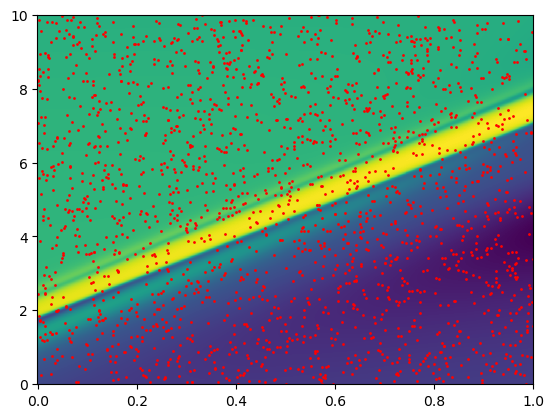

In [35]:
x_array = torch.linspace(0, L, 1000)
t_array = torch.linspace(0, T, 1000)

x_show = x_phys.detach().numpy()

X, Y = np.meshgrid(x_array, t_array)
input_test = np.stack(
    [X.reshape(-1), Y.reshape(-1)]
)

with torch.no_grad():
    output_test = model(input_test)
    v = output_test[0, :]
    V = v.reshape(1000, 1000)

fig = plt.figure()
ax = fig.subplots()
ax.pcolormesh(X, Y, V)
ax.scatter(x_show[0, :], x_show[1, :], c="r", s=1)


In [40]:
x_arr = torch.linspace(0, 1, 100)
t_arr = torch.linspace(0, 10, 100)
X, T = torch.meshgrid(x_arr, t_arr)
in_test = torch.stack((X.reshape(-1), T.reshape(-1)), 0)
in_test.requires_grad_(True)

y_nn = model(in_test)

v_grad = torch.autograd.grad(
    y_nn[0,:],
    in_test,
    grad_outputs=torch.ones_like(y_nn[0,:]),
    retain_graph=True,
    create_graph=True
)[0]
i_grad = torch.autograd.grad(
    y_nn[1,:],
    in_test,
    grad_outputs=torch.ones_like(y_nn[1,:]),
    retain_graph=True,
    create_graph=True
)[0]

v_x = v_grad[0, :]
v_t = v_grad[1, :]
i_x = i_grad[0, :]
i_t = i_grad[1, :]

v_x_grad = torch.autograd.grad(
    v_x,
    in_test,
    grad_outputs=torch.ones_like(v_x),
    retain_graph=True
)[0]

i_x_grad = torch.autograd.grad(
    i_x,
    in_test,
    grad_outputs=torch.ones_like(v_x),
    retain_graph=True
)[0]

v_xx = v_x_grad[0,:]
i_xx = i_x_grad[0,:]

gamma = 0.01

eq_1 = v_x + coeff.L * i_t + coeff.R * y_nn[1,:] + gamma * i_xx
eq_2 = i_x + coeff.C * v_t + coeff.G * y_nn[0,:] * gamma * v_xx

full_error = torch.square(eq_1) + torch.square(eq_2)

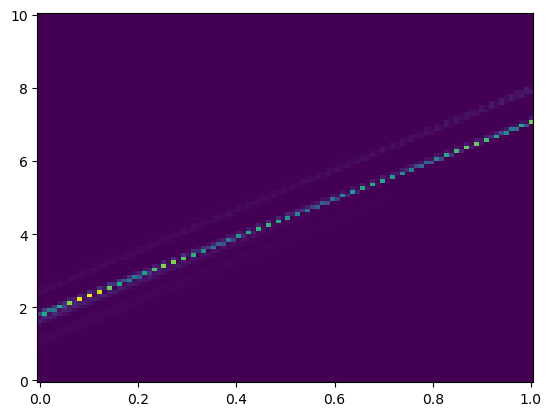

In [41]:
phys_grid = full_error.reshape((100, 100))

fig = plt.figure()
ax = fig.subplots()
ax.pcolormesh(X, T, phys_grid.detach().numpy())

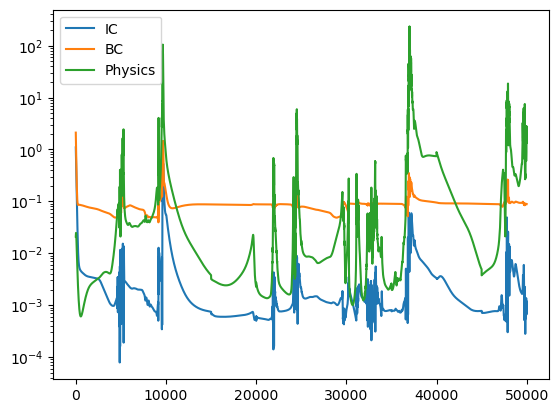

In [30]:
n = np.arange(len(phys_loss_hist))
fig = plt.figure()
ax = fig.subplots()

ax.semilogy(n, ic_loss_hist)
ax.semilogy(n, bc_loss_hist)
ax.semilogy(n, phys_loss_hist)
ax.legend(["IC", "BC", "Physics"])